![Alt text](image.png)

#### 0. SUMMARY
This code uses the artificial recurrent neural network: Long Short Term Memory (LSTM) to predict the closing price of MICROSOFT stock using the past 60 days stock price.

The Long Short-Term Memory (LSTM) is a type of Recurrent Neural Network (RNN) that is specifically designed to handle sequential data, such as time series, speech, and text

The code downloads the stock market data for MSFT from Yahoo Finance. The data is split into a training set and a test set. The training set is used to train the model, while the test set is used to evaluate the model's performance.

The LSTM model is created using the Sequential class from TensorFlow. The model has two LSTM layers, each with 50 units. The output of the LSTM layers is then passed through a Dense layer with 25 units. The final layer is a Dense layer with 1 unit, which represents the predicted stock price. The model is trained using the fit method. The fit method takes the training data and the number of epochs as input. The number of epochs is the number of times the model will be trained on the data.

After the model is trained, it is evaluated on the test set. The evaluation metric used is the root mean squared error (RMSE). The RMSE is a measure of the difference between the predicted values and the actual values.

The code then predicts the closing price of MSFT for September 1st, 2023. The prediction is USD 275.22.

Finally, the code predicts the stock price trend in the first 15 days of September. The code predicts an upward trend in the stock price in the coming days.

Inspiration:
https://medium.com/@fouadkz/stock-price-prediction-using-lstm-97f0fff454b

The flowchart below shows the steps involved in creating the LSTM model. First, the input data was preprocessed and split into training and validation sets. Next, the LSTM layer was added to the model with a specified number of hidden units and activation function. Then, the output layer was added with a linear activation function to predict the target variable. Finally, the model was compiled and trained using an optimizer, a loss function and a metric.

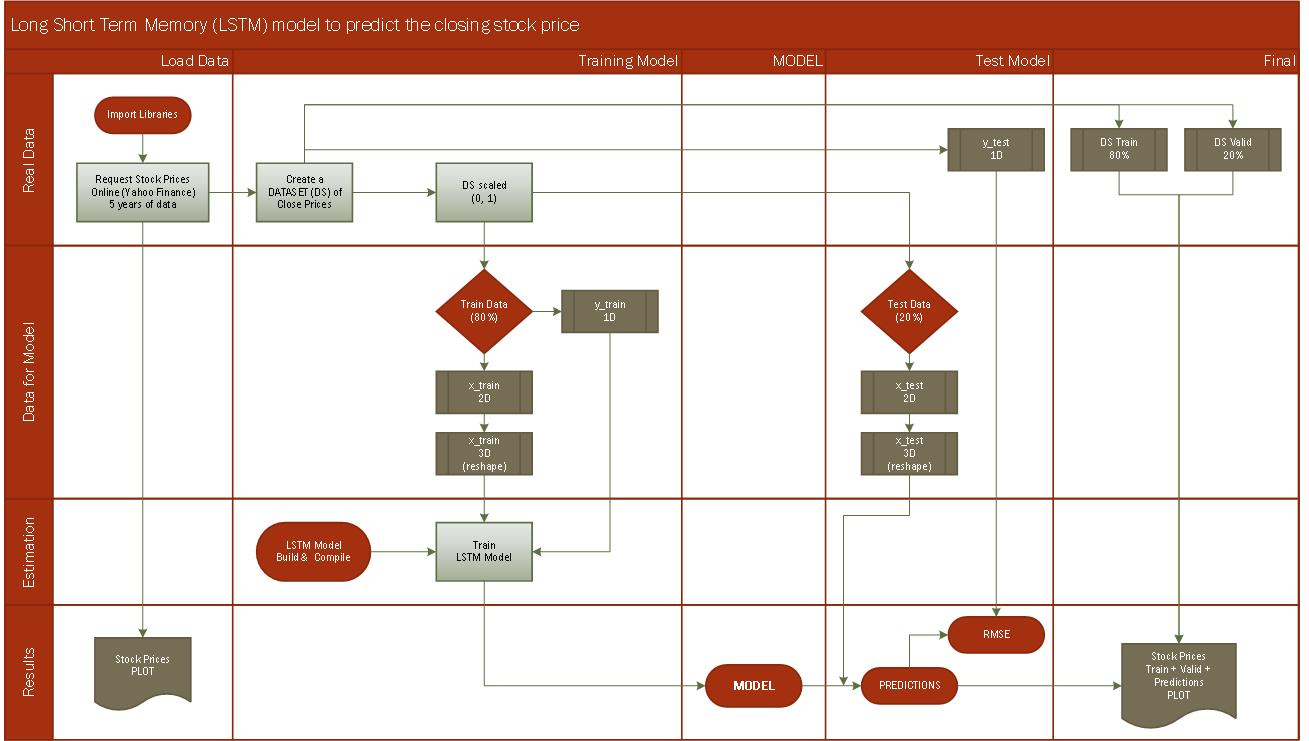


In [1]:
#Importing libraires
import math
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

2023-09-11 15:56:22.803252: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-11 15:56:23.173429: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-11 15:56:23.175642: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 15:56:24.605018: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### 1. DATA SOURCE
There are many free sources of stock market data available online. I chose Yahoo Finance to import the stock prices. The following code will get the stock price data for SPY from Yahoo Finance. The data will be downloaded for the period from January 1, 2020 to August 31, 2023.

In [2]:
#Get the stock market data from Yahoo Finance
sym   = 'MSFT'
start = '2016-01-01'
end   = '2023-09-01'
stock_market_data = yf.download(sym, start=start, end=end)

[*********************100%%**********************]  1 of 1 completed


#### 2. DATA REVIEW

In [3]:
stock_market_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1929 entries, 2016-01-04 to 2023-08-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1929 non-null   float64
 1   High       1929 non-null   float64
 2   Low        1929 non-null   float64
 3   Close      1929 non-null   float64
 4   Adj Close  1929 non-null   float64
 5   Volume     1929 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 105.5 KB


In [4]:
stock_market_data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
stock_market_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,54.320000,54.799999,53.389999,54.799999,48.797729,53778000
2016-01-05,54.930000,55.389999,54.540001,55.049999,49.020348,34079700
2016-01-06,54.320000,54.400002,53.639999,54.049999,48.129875,39518900
2016-01-07,52.700001,53.490002,52.070000,52.169998,46.455795,56564900
2016-01-08,52.369999,53.279999,52.150002,52.330002,46.598270,48754000
...,...,...,...,...,...,...
2023-08-25,321.470001,325.359985,318.799988,322.980011,322.980011,21684100
2023-08-28,325.660004,326.149994,321.720001,323.700012,323.700012,14808500
2023-08-29,321.880005,328.980011,321.880005,328.410004,328.410004,19284600


In [6]:
stock_market_data.shape

(1929, 6)

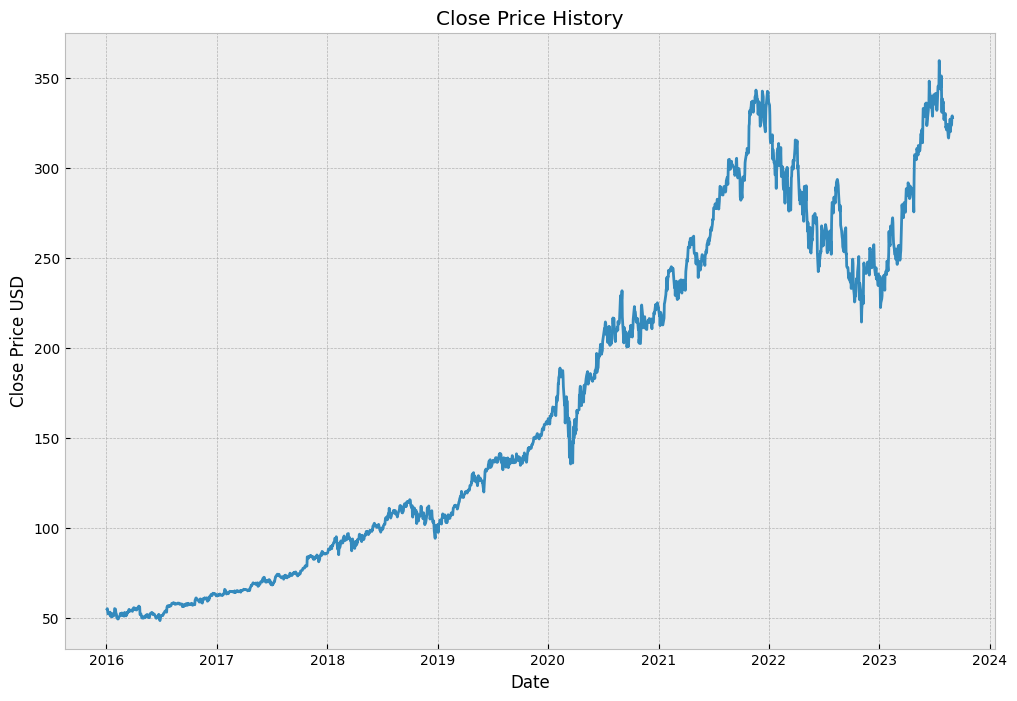

In [7]:
plt.figure(figsize=(12,8))
plt.style.use('bmh')
plt.plot(stock_market_data['Close'])
plt.title('Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price USD');

#### 3. MACHINE LEARNING MODEL

In [8]:
#DATA PREPARATION FOR TRAINING THE MODEL
#Extract 'Close' prices column and convert to numpy 2D
close_price = stock_market_data['Close']
price = close_price.to_numpy().reshape(close_price.shape[0],1)

#Scale prices to 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
price_scaled = scaler.fit_transform(price)

#Training set length = 80% of 'price_scaled'
train_len = math.ceil(len(price_scaled)*0.8)

#Slice 'price scaled' to obtain training data for train lists
train_data = price_scaled[0:train_len , :]

#Split the 'test_data' into x_train and y_train lists
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

#Convert 'y_train' list into numpy 1D
y_train = np.array(y_train)

#Convert 'x_train' list into numpy 3D
x_train = np.array(x_train)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
print('Data size for training the LSTM Model:', x_train.shape)

Data size for training the LSTM Model: (1484, 60, 1)


In [9]:
#LSTM MODEL
# Build the model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compile the model
model.compile(optimizer="adam", loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)
print('LSTM model created successfully')

1484/1484 [==============================] - 61s 39ms/step - loss: 0.0014
LSTM model created successfully


In [10]:
#DATA PREPARATION FOR TEST THE MODEL
#Slice 'price' to obtain 'y_test' (stock price values)
y_test = price[train_len:, : ]

#Slice 'price scaled' to obtain 'test_data' for 'x_test'
test_data = price_scaled[train_len-60: , :]

#Create the x_test list from 'test_data'
x_test = []

for i in range (60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

#Convert 'x_test' list into numpy 3D
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_train.shape[1],1))
print('Data size for test the LSTM Model:', x_test.shape)

Data size for test the LSTM Model: (385, 60, 1)


In [11]:
#TESTING LSTM MODEL
#Get Prediction Stock Price Values from Model
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
print('LSTM model predictions created successfully')

13/13 [==============================] - 1s 28ms/step
LSTM model predictions created successfully


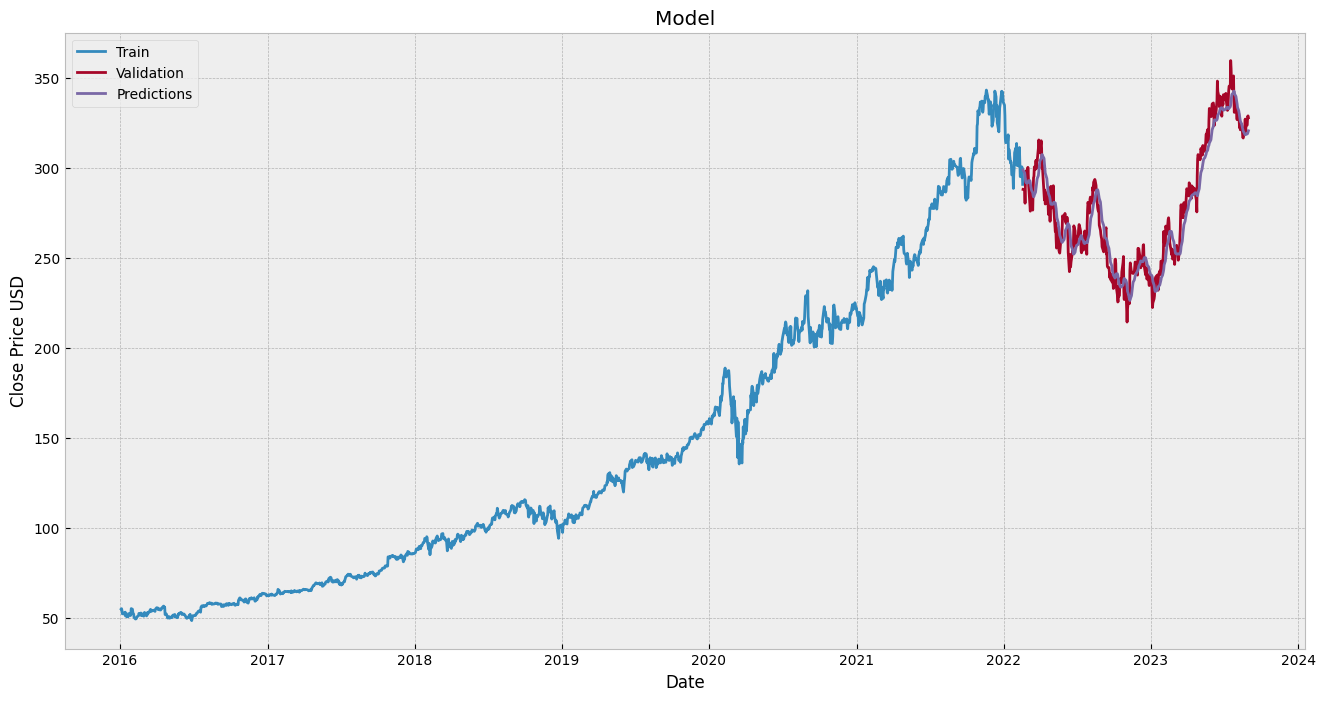

In [12]:
#VISUALIZATION
#Data for plot
train = pd.DataFrame(close_price[:train_len])
valid = pd.DataFrame(close_price[train_len:])
valid['Predictions'] = predictions

#Plot results
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train)
plt.plot(valid)
plt.legend(['Train', 'Validation', 'Predictions'])
plt.show();

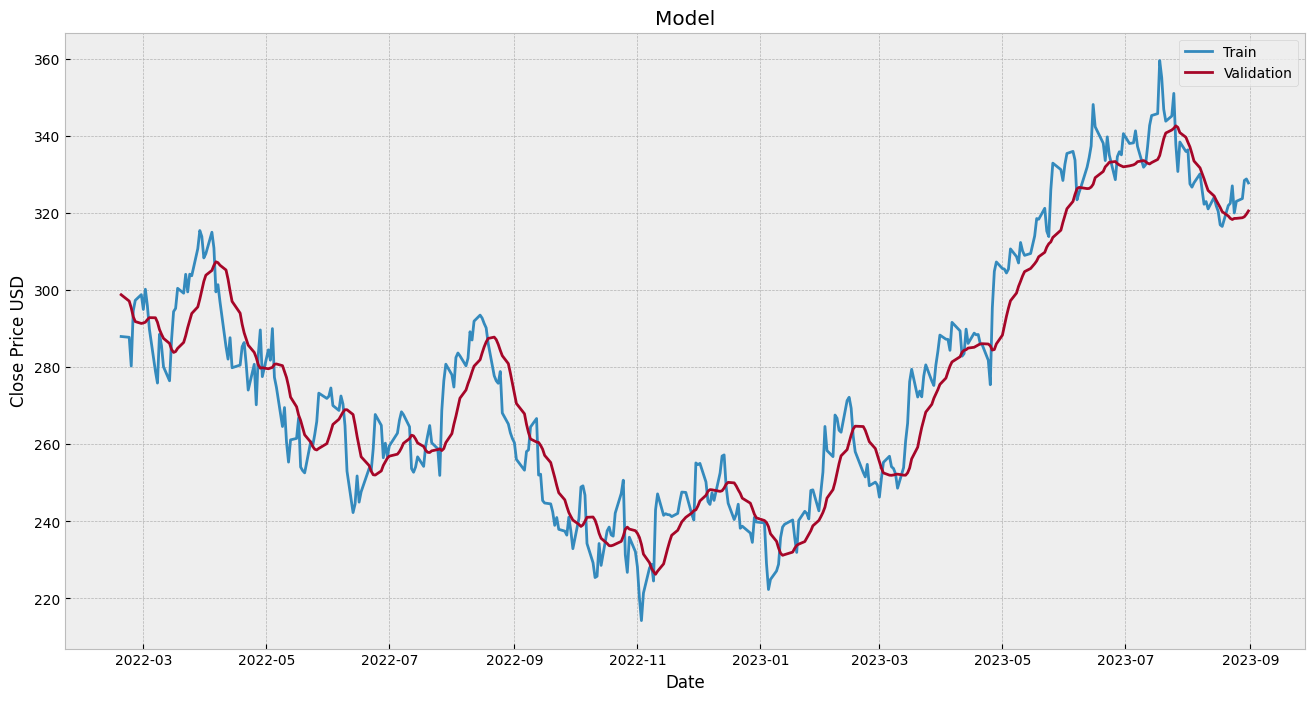

,Close,Predictions
Date,,
2022-02-18,287.929993,298.764282
2022-02-22,287.720001,297.107269
2022-02-23,280.269989,295.342560
2022-02-24,294.589996,293.062042
2022-02-25,297.309998,291.799347
...,...,...
2023-08-25,322.980011,318.562531
2023-08-28,323.700012,318.728882
2023-08-29,328.410004,318.991974


In [13]:
#Plot Valid section
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(valid)
plt.legend(['Train', 'Validation', 'Predictions'])
plt.show();
valid

In [14]:
# Export the model
# model.save('MSFT_Stock_Predictive_Model.h5')

/home/ahow/stock_price_model/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### 4. QUESTIONS

1. What is the RMSE of the LSTM model?

In [15]:
#Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((predictions-y_test)**2))
rmse = round(rmse, 1)
print('The Root Mean Squared Error (RMSE):', rmse)

The Root Mean Squared Error (RMSE): 9.6


2. What is the predicted closing price of MICROSOFT (MSFT) for September 1st, 2023?

In [425]:
sym   = 'MSFT'
date = '2023-09-01'

#GET STOCK PRICES
import datetime
date = datetime.datetime.strptime(date, "%Y-%m-%d")
start = date + datetime.timedelta(days=-120)
end   = date + datetime.timedelta(days=0)
start = start.strftime("%Y-%m-%d")
end = end.strftime("%Y-%m-%d")
stock_prices = yf.download(sym, start=start, end=end)

#DATA PREPARATION
#Extract 'Close' prices column and convert to numpy 2D
close_prices = stock_prices['Close']
prices = close_prices.to_numpy().reshape(close_prices.shape[0],1)
#Get the last 60 days closing price values and convert it to an array
last_60_days = prices[-60:]
#Scale prices to 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
values = scaler.fit_transform(last_60_days)
#Empty list
x_test2 = []
#Append in the list
x_test2.append(values)
#convert x_test2 to numpy array
x_test2 = np.array(x_test2)

#PRICE PREDITECTED
pre_price = model.predict(x_test2)
#undo scaling
pre_price = scaler.inverse_transform(pre_price)
pre_price = round(pre_price[0,0],2)

print('----------------------------------------')
print()
print('For the date {} the predited price is USD'. format(end), pre_price)
print()
print('----------------------------------------')


[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 37ms/step
----------------------------------------

For the date 2023-09-01 the predited price is USD 324.09

----------------------------------------


3. What is the stock price trend in the first 15 days of September?

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 35ms/step
----------------------------------------
LSTM model predictions created successfully
----------------------------------------


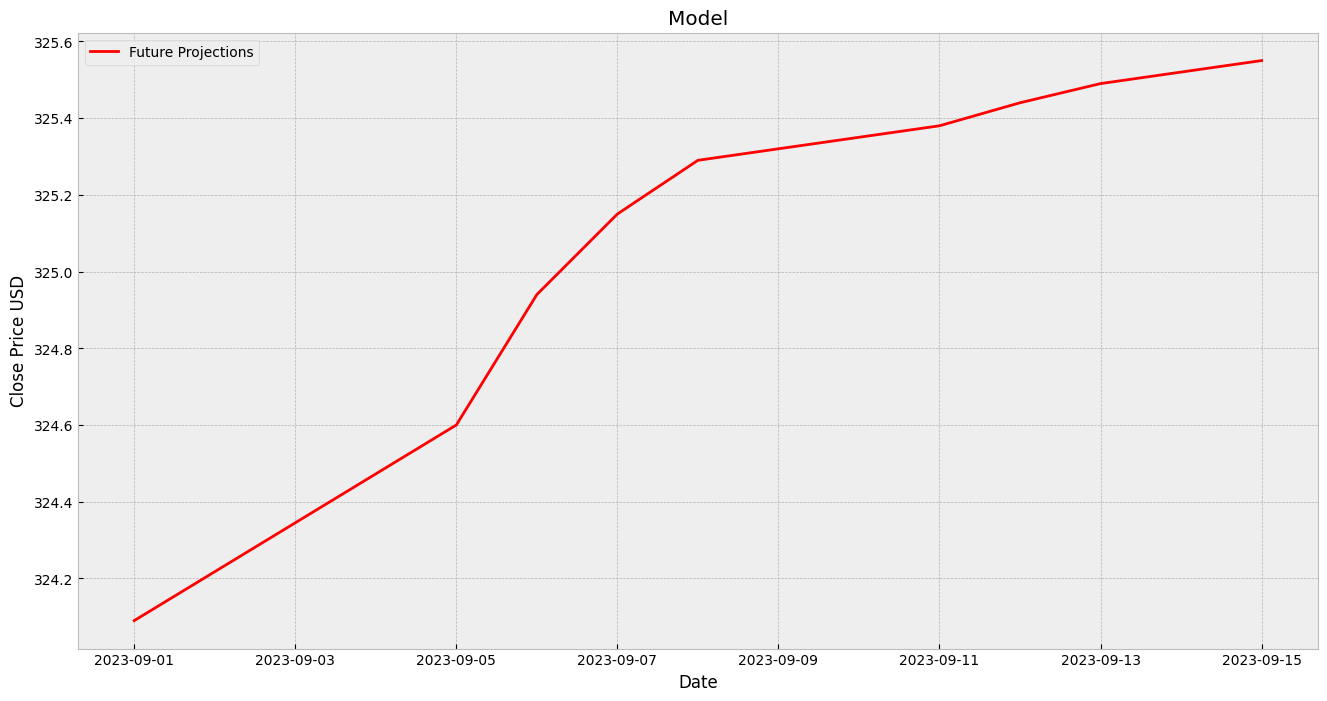

An upward trend is projected in the stock price in the coming days


In [426]:
#There are 10 working days from Sept 1 to Sept 15
days_list = ['2023-09-01','2023-09-05','2023-09-06','2023-09-07','2023-09-08','2023-09-11','2023-09-12','2023-09-13','2023-09-14','2023-09-15']

#price List for predictions
x_list = []
x_list.append(values)
x_list = np.array(x_list)

#loop for predictions
x_pred = x_list
y_list = []
for i in range(len(days_list)):
  # Get the last 60 values of x_pred
  x_pred_new = x_pred[:, -60:]

  # Calculate y_pred
  y_pred = model.predict(x_pred_new)

  # Calculate y price
  y_price = scaler.inverse_transform(y_pred)
  y_price = round(y_price[0,0],2)
  y_list.append(y_price)

  # Insert y_pred into x_pred
  x_pred = np.concatenate((x_pred, y_pred[:, None]), axis=1)
print('----------------------------------------')
print('LSTM model predictions created successfully')
print('----------------------------------------')

#Data for plot
days = pd.DataFrame(days_list,columns=['Dates'])
days = pd.to_datetime(days['Dates'])
y_prices = pd.DataFrame(y_list,columns=['Price'])
projection = pd.concat([days,y_prices], axis=1)
projection = projection.set_index('Dates')

#Plot projection
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(projection,color='red')
plt.legend(['Future Projections'])
plt.show();

print('An upward trend is projected in the stock price in the coming days')

#### 5. CONCLUSION 

The code is a good example of how machine learning can be used to predict stock prices. The model is able to learn from historical data and make accurate predictions about future prices. However, it is important to note that machine learning models are not perfect and can sometimes make mistakes. It is always advisable to do your own research before making any investment decisions.